# Using the Neural network from Tensorflow to predict bike sharing.

In this project, you'll build your neural network from Tensorflow and use it to predict daily bike rental ridership.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

### Load and prepare the data

In [2]:
data_path = 'Bike-Sharing-Dataset/hour.csv'

rides = pd.read_csv(data_path)
rides.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


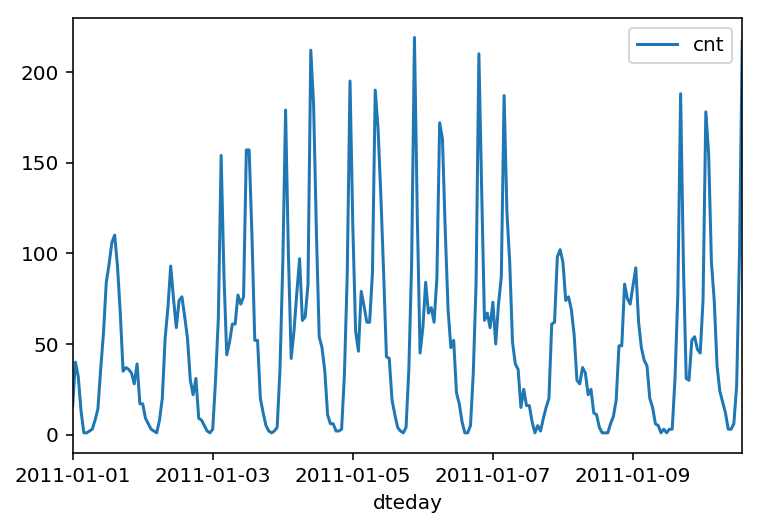

In [3]:
rides[:24*10].plot(x='dteday', y='cnt')

### Dummy variables

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)
data.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


### Scaling target variables

In [5]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

### Splitting the data into training, testing, and validation sets

In [6]:
# Save data for approximately the last 21 days 
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]

In [7]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

### Implement Neural Network using Tensorflow
Reasonable people can disagree about whether using neural networks for regression is overkill. The point of this implemment is for learning.

In [64]:
n_dim = train_features.shape[1]


tf.reset_default_graph()


X = tf.placeholder(tf.float32, [None, n_dim])
Y = tf.placeholder(tf.float32, [None, 1])      

W1 = tf.Variable(tf.truncated_normal([n_dim,1]), name="weight")
b1 = tf.Variable(tf.truncated_normal([n_dim]), name="bias")

h1 = tf.nn.relu(tf.matmul(X,W1) + b1)

W2 = tf.Variable(tf.truncated_normal([n_dim,1]), name="weight")
b2 = tf.Variable(tf.truncated_normal([1]), name="bias")


y_ = tf.add(tf.matmul(h1, W2),b2)

cost_function = tf.reduce_mean(tf.square(y_ - Y))

### Choose the learning rate
This scales the size of weight updates. If this is too big, the weights tend to explode and the network fails to fit the data. A good choice to start at is 0.1. If the network has problems fitting the data, try reducing the learning rate.

### Choose the number of iterations
The more iterations you use, the better the model will fit the data. However, if you use too many iterations, then the model with not generalize well to other data, this is called overfitting. You want to find a number here where the network has a low training loss, and the validation loss is at a minimum.

In [98]:
### Set the hyperparameters here ###
learning_rate = 0.03
training_epochs = 2000

In [99]:
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_function) 

In [100]:
yy = np.array([[i] for i in train_targets['cnt']])
yyy = np.array([[i] for i in test_targets['cnt']])

In [101]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

cost_history = np.empty(shape=[1],dtype=float)

for epoch in range(training_epochs):
    sess.run(optimizer,feed_dict={X:np.array(train_features),Y:yy})
    cost_history = np.append(cost_history,sess.run(cost_function,feed_dict={X:np.array(train_features),Y:yy}))

### Performance Evaluation

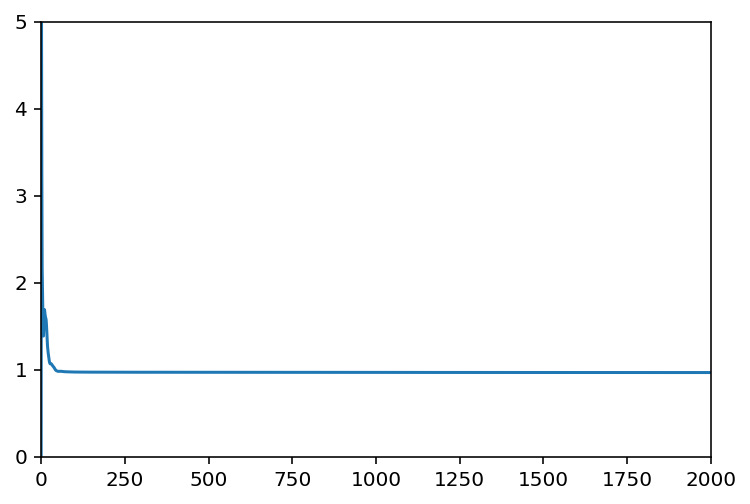

In [102]:
plt.plot(range(len(cost_history)),cost_history)
#plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.axis([0,training_epochs,0,5])
plt.show()

In [103]:
pred_y = sess.run(y_, feed_dict={X: np.array(test_features)})
mse = tf.reduce_mean(tf.square(pred_y - yyy))
print("MSE: %.4f" % sess.run(mse)) 

MSE: 0.7222


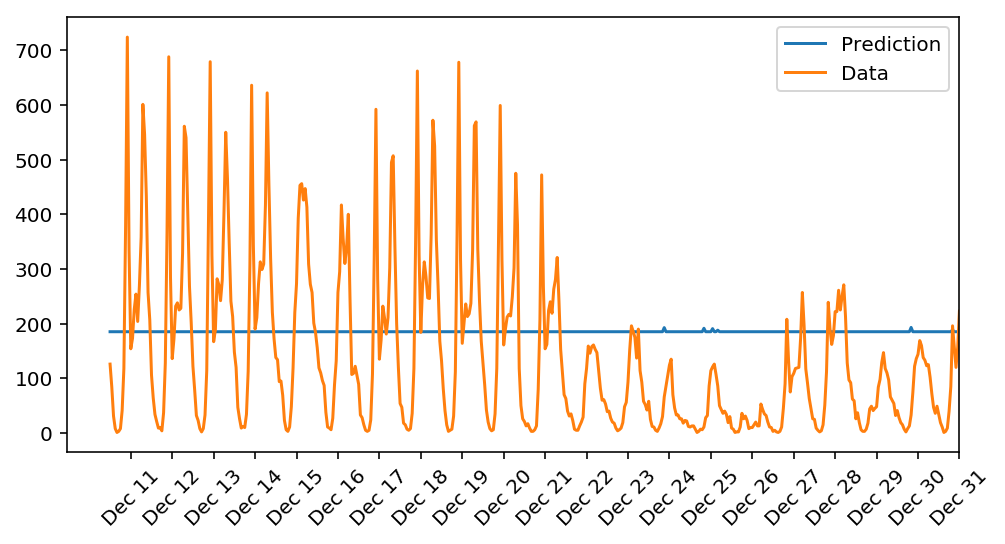

In [104]:
fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['cnt']

pred_y = sess.run(y_, feed_dict={X: np.array(test_features)}).T*std + mean
ax.plot(pred_y[0], label='Prediction')
ax.plot((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(pred_y))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)